# Workplace attitudes towards mental health and their impact on employee productivity
A Tutorial and Introduction to the Data Science Pipeline by Gabrielle Baniqued

# What is the Data Science Pipeline?
Our walkthrough of the Data Science Pipeline will consist of the following:
<li>Data Collection</li>
<li>Data Management and Representation</li>
<li>Exploratory Data Analysis</li>
<li>Analysis, Hypothesis Testing, and Machine Learning</li>
<li>Insight and Discussion</li>

Although this tutorial will follow this in order, something important to remember is that this 'pipeline' is not necessarily a step-by-step/one-and-done process. Often we will be required to circle back, repeat steps, rethink methods, and maybe even start from square one.

# Introduction - Why Track Attitudes towards Mental Illness?
In 2012, the Center for Disease Control (CDC) released a report, <a href="https://www.cdc.gov/hrqol/Mental_Health_Reports/pdf/BRFSS_Full%20Report.pdf">Attitudes Toward Mental Illness</a>, where they highlighted the value of tracking attitudes towards mental health. Some of their conclusions include:
<li>Beliefs and attitudes about mental illness might predict if an individual discloses symptoms or seek treatment/support</li>
<li>Individuals are less likely to disclose mental illness/seek support if there is perceived stigma around it in their community</li>
<li>The probability of adults receiving mental health treatment increased when states provided more funding/made it more accessible</li>
<li>Statewide, positive attitudes towards receiving treatment for mental disorders was associated with higher per capita expenditure on state mental health agencies</li>

On a state level, the CDC found lack of accessibility to mental health resources and negative stigma around the topic was correlated to less individuals seeking mental health treatment. On the other hand, states where attitudes towards mental health were positive (i.e., believing treatment is effective and important) and resources were within access, also saw an increase in the number of individuals benefiting from treatments for mental disorders.

The following project takes the reasoning from the aforementioned CDC study and applies it to a different environment.

We will be exploring the following inquiry: <b><i>do workplace attitudes about mental health influence employee productivity?</i></b>


# 1. Data Collection

To answer our inquiry, we will be using OSMI (Open Sourcing Mental Illness, LTD) survey data from 2014 and 2016 regarding mental health in the tech workplace.

Sometimes, data will have to be collected (ex. web scraping), parsed through, and organized before we can actually start using it. In this case, however, the data has been collected for us. 

The survey data can be downloaded as csv files from Kaggle:

<li><a href="https://www.kaggle.com/osmi/mental-health-in-tech-survey">OSMI Mental Health in Tech Survey (2014)</a></li>
<li><a href="https://www.kaggle.com/osmi/mental-health-in-tech-2016">OSMI Mental Health in Tech Survey (2016)</a></li>
Both of these surveys aimed to measure attitudes towards mental health and frequency of mental health disorders among tech workers.

In [1]:
#import statements
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from collections import defaultdict
import random
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

In [2]:
# supresses warnings because we're dangerous
warnings.filterwarnings('ignore')

In [3]:
# removes max display for rows and cols
pd.set_option("display.max_rows", None, "display.max_columns", None)

# import 2014 survey using pandas
survey_2014 = pd.read_csv('survey.csv')

<b>Summary of the 2014 dataset: </b>The 2014 survey dataset (survey_2014) consists of 1259 valid responses (rows) with 27 attributes (columns). The target audience for this survey was employees in the tech workplace.

In [4]:
# displays first 3 rows of 2014 survey data in a DataFrame
survey_2014.head(3)

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,No,Yes,Yes,Not sure,No,Yes,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,No,No,Don't know,No,Don't know,Don't know,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,No,Yes,No,No,No,No,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN


In [5]:
# Here, I decide to drop the free-response column [comments],
# since I know I don't want to include that data in my analysis.
# I also drop the Timestamp column ahead of time, since the 2016
# survey lacks Timestamp data, and we eventually want to combine the two.
subset_2014 = survey_2014.drop(columns=['comments', 'Timestamp'])

# Here, I drop any invalid rows (if present), where all the values are NaN.
subset_2014.dropna(how='all', inplace=True)

<b>Summary of the 2016 dataset: </b>The 2016 survey dataset (survey_2016) consists of 1433 valid responses (rows) with 63 attributes (columns). The target audience for this survey remained the same as the 2014 survey (employees in the tech workplace.)

In [6]:
# import 2016 survey using pandas
survey_2016 = pd.read_csv('mental-heath-in-tech-2016_20161114.csv')

# display first 2 rows of the 2016 data
survey_2016.head(2)

,Are you self-employed?,How many employees does your company or organization have?,Is your employer primarily a tech company/organization?,Is your primary role within your company related to tech/IT?,Does your employer provide mental health benefits as part of healthcare coverage?,Do you know the options for mental health care available under your employer-provided coverage?,"Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?",Does your employer offer resources to learn more about mental health concerns and options for seeking help?,Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?,"If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:",Do you think that discussing a mental health disorder with your employer would have negative consequences?,Do you think that discussing a physical health issue with your employer would have negative consequences?,Would you feel comfortable discussing a mental health disorder with your coworkers?,Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?,Do you feel that your employer takes mental health as seriously as physical health?,Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?,Do you have medical coverage (private insurance or state-provided) which includes treatment of mental health issues?,Do you know local or online resources to seek help for a mental health disorder?,"If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to clients or business contacts?","If you have revealed a mental health issue to a client or business contact, do you believe this has impacted you negatively?","If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to coworkers or employees?","If you have revealed a mental health issue to a coworker or employee, do you believe this has impacted you negatively?",Do you believe your productivity is ever affected by a mental health issue?,"If yes, what percentage of your work time (time performing primary or secondary job functions) is affected by a mental health issue?",Do you have previous employers?,Have your previous employers provided mental health benefits?,Were you aware of the options for mental health care provided by your previous employers?,Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?,Did your previous employers provide resources to learn more about mental health issues and how to seek help?,Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?,Do you think that discussing a mental health disorder with previous employers would have negative consequences?,Do you think that discussing a physical health issue with previous employers would have negative consequences?,Would you have been willing to discuss a mental health issue with your previous co-workers?,Would you have been willing to discuss a mental health issue with your direct supervisor(s)?,Did you feel that your previous employers took mental health as seriously as physical health?,Did you hear of or observe negative consequences for co-workers with mental health issues in your previous workplaces?,Would you be willing to bring up a physical health issue with a potential employer in an interview?,Why or why not?,Would you bring up a mental health issue with a potential employer in an interview?,Why or why not?.1,Do you feel that being identified as a person with a mental health issue would hurt your career?,Do you think that team members/co-workers would view you more negatively if they knew you suffered from a menta

Here, you can see that the column names are different from the 2014 data; there are actually new columns in the 2016 data! In order to combine these two DataFrames, we are going to rename the 2016 columns, drop any columns non-existing in the 2014 survey data, then concatenate the two DataFrames.

In [7]:
# The DataFrame.rename method requires a dictionary for renaming
# which we are filling below, beginning with defaultdict().
rename_dict = defaultdict()

# Inserting keys as the columns to be renamed
for col in survey_2016.columns:
    rename_dict[col] = ""

# Values list for the rename dict
rename_list = ['self_employed', 'no_employees', 'tech_company', 'primary_role', 'benefits', 
               'care_options', 'wellness_program', 'seek_help', 'anonymity',
              'leave', 'mental_health_consequence', 'phys_health_consequence',
              'coworkers', 'supervisor', 'mental_vs_physical', 'obs_consequence',
              'coverage', 'resources', 'revtoclients', 'revclient_consequence',
              'revtocoworkers', 'revcoworker_consequence', 'work_interfere', 'interfere_amt',
              'prev_employers', 'prev_benefits', 'prev_care_options', 'prev_wellness_program',
              'prev_seek_help', 'prev_anonymity', 'prev_mentalhealthconsequence',
              'prev_physhealthconsequence', 'prev_coworkers', 'prev_supervisors',
              'prev_mentalvsphysical', 'prev_obs_consequence', 'mentalhealthinterview',
              'mentalhealthinterview_why', 'physhealthinterview', 'physhealthinterview_why',
              'identify_mental', 'viewed_negatively_mental', 'willingtoshare', 'obs_unsupportive',
              'obs_unsupportive_affect', 'family_history', 'disorder_past', 'disorder_curr','disorder_past_yes',
              'disorder_past_maybe', 'diagnosed', 'diagnosed_conditions', 'treatment',
               'work_interfere_withtreat', 'work_interfere_notreat', 'Age', 'Gender', 'Country',
              'state', 'Country_repeat', 'state_repeat', 'work_position', 'remote_work'] 

# Inserting the values to rename
for i in range(len(rename_list)):
    k = list(rename_dict.keys())[i]
    v = rename_list[i]
    rename_dict[k] = v

# Based on the dict we created above, we rename the columns here.
subset_2016 = survey_2016.rename(columns=rename_dict)

# Similar to the 2014 DataFrame, I am dropping the free response columns.
subset_2016.drop(columns=['mentalhealthinterview_why', 'physhealthinterview_why'])

# Similarly, I drop any invalid rows (if present), where all the values are NaN.
subset_2016.dropna(how='all', inplace=True)

# Outputting the modified version
subset_2016.head(3)

,self_employed,no_employees,tech_company,primary_role,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_vs_physical,obs_consequence,coverage,resources,revtoclients,revclient_consequence,revtocoworkers,revcoworker_consequence,work_interfere,interfere_amt,prev_employers,prev_benefits,prev_care_options,prev_wellness_program,prev_seek_help,prev_anonymity,prev_mentalhealthconsequence,prev_physhealthconsequence,prev_coworkers,prev_supervisors,prev_mentalvsphysical,prev_obs_consequence,mentalhealthinterview,mentalhealthinterview_why,physhealthinterview,physhealthinterview_why,identify_mental,viewed_negatively_mental,willingtoshare,obs_unsupportive,obs_unsupportive_affect,family_history,disorder_past,disorder_curr,disorder_past_yes,disorder_past_maybe,diagnosed,diagnosed_conditions,treatment,work_interfere_withtreat,work_interfere_notreat,Age,Gender,Country,state,Country_repeat,state_repeat,work_position,remote_work
0,0,26-100,1.0,NaN,Not eligible for coverage / N/A,NaN,No,No,I don't know,Very easy,No,No,Maybe,Yes,I don't know,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,"No, none did",N/A (not currently aware),I don't know,None did,I don't know,Some of them,None of them,Some of my previous employers,Some of my previous employers,I don't know,None of them,Maybe,NaN,Maybe,NaN,Maybe,"No, I don't think they would",Somewhat open,No,NaN,No,Yes,No,NaN,NaN,Yes,"Anxiety Disorder (Generalized, Social, Phobia,...",0,Not applicable to me,Not applicable to me,39,Male,United Kingdom,NaN,United Kingdom,NaN,Back-end Developer,Sometimes
1,0,6-25,1.0,NaN,No,Yes,Yes,Yes,Yes,Somewhat easy,No,No,Maybe,Yes,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,"Yes, they all did",I was aware of some,None did,Some did,"Yes, always",None of them,None of them,"No, at none of my previous employers",Some of my previous employers,Some did,None of them,Maybe,It would depend on the health issue. If there ...,No,While mental health has become a more prominen...,"No, I don't think it would","No, I don't think they would",Somewhat open,No,NaN,Yes,Yes,Yes,"Anxiety Disorder (Generalized, Social, Phobia,...",NaN,Yes,"Anxiety Disorder (Generalized, Social, Phobia,...",1,Rarely,Sometimes,29,male,United States of America,Illinois,United States of America,Illinois,Back-end Developer|Front-end Developer,Never
2,0,6-25,1.0,NaN,No,NaN,No,No,I don't know,Neither easy nor difficult,Maybe,No,Maybe,Maybe,I don't know,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,"No, none did",N/A (not currently aware),None did,Some did,I don't know,I don't know,Some of them,Some of my previous employers,I don't know,I don't know,Some of them,Yes,"They would provable need to know, to Judge if ...",Yes,"Stigma, mainly.",Maybe,Maybe,Somewhat open,Maybe/Not sure,Yes,No,Maybe,No,NaN,NaN,No,NaN,1,Not applicable to me,Not applicable to me,38,Male,United Kingdom,NaN,United Kingdom,NaN,Back-end Developer,Always


In [8]:
# Dropping columns that aren't found in the 2014 survey (I know. After we did all that work to rename it all nicely!)
subset_2016.drop(columns=['Country_repeat', 'state_repeat', 'work_position','interfere_amt',
              'prev_employers', 'prev_benefits', 'prev_care_options', 'prev_wellness_program',
              'prev_seek_help', 'prev_anonymity', 'prev_mentalhealthconsequence',
              'prev_physhealthconsequence', 'prev_coworkers', 'prev_supervisors',
              'prev_mentalvsphysical', 'prev_obs_consequence', 'mentalhealthinterview', 'physhealthinterview',
              'identify_mental', 'viewed_negatively_mental', 'willingtoshare', 'obs_unsupportive',
              'obs_unsupportive_affect', 'disorder_past', 'disorder_curr','disorder_past_yes',
              'disorder_past_maybe', 'diagnosed', 'diagnosed_conditions', 'revtoclients', 'revclient_consequence',
              'revtocoworkers', 'revcoworker_consequence', 'coverage', 'primary_role', 'resources'], inplace=True)

In [9]:
# Now, combining the two DataFrames is easy.
survey = pd.concat([subset_2014, subset_2016])
survey.head(3)

,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,mentalhealthinterview_why,physhealthinterview_why,work_interfere_withtreat,work_interfere_notreat
0,37,Female,United States,IL,NaN,No,Yes,Often,6-25,No,Yes,Yes,Not sure,No,Yes,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN,NaN,NaN,NaN
1,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,No,No,Don't know,No,Don't know,Don't know,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN,NaN,NaN,NaN
2,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,No,Yes,No,No,No,No,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN,NaN,NaN,NaN


# 2. Data Management and Representation

If we wanted to use all of our survey data, it would be valuable for us to clean all of it and discuss it. In this case, we are looking ahead and letting our later part of the project (machine learning, modeling, etc.) inform the data we should tidy.

## Preparing for later modeling - target and predictor values
Now that our two surveys are combined into one DataFrame, we can decide on our predictors and target for our modeling later on.

Out of all of the columns (in our modified DataFrame), two measures of mental wellness can be found in treatment and work_interfere. My specific inquiry: the effect of mental health on productivity, is best measured by work_interfere. <b>We will choose <i>work_interfere</i> as our target.</b>

### Thinking ahead: Tidying Gender, Age, family_history
Intuitively, I can identify some 'obvious' predictors: gender, age, family_history. These predictors have to do with the employee his/her/themself.

However, for my specific inquiry, I would like to try to identify predictors on behalf of the workplace: workplace size, culture, attitudes towards mental health and determine their signifiance. In addition to predictors related to the employee, we will also focus on predictors regarding the workplace.

<b>Gender:</b> This question in the survey was free response, leaving us a lot of data to clean up. Gender is also increasingly being understood as non-binary, i.e., not just Male/Female. We will clean up, group the gender responses into three categories, and then assign each category a numerical value: Male: 0, Female: 1, and Nonbinary: 2, to use for Logistic Regression later on.

<b>Age:</b> After getting rid of any invalid ages, we will keep age as a continuous variable (vs. making into a categorial variable).

<b>family_history:</b> This question is answered by 'Yes', 'No', or 'I don't know'. 'I don't know' will be processed as a NaN value, and 'Yes' and 'No' will also be assigned numerical values, 0 for No, 1 for Yes.

### Thinking ahead: Tidying no_employees and measuring workplace culture/attitude
<b>no_employees:</b> The survey already provides us with grouped company sizes: 1-5, 6-25, 26-100, 100-500, 500-1000, More than 1000. We will stick with these groupings.

Measuring workplace culture/attitude: However, 'workplace culture' or 'attitudes' are more difficult to measure based on the data we are given. Our plan is, for each response, to score the responses related to the workplace culture/attitudes questions (which are generally answered in a 'Yes, Maybe, No' fashion) and assign a workplace_score to each employee/row. For simplicity, we will weight each question equally.

<b>However, we can't just naively assign Yes as +1 and No as -1,</b> since the meaning of the answer depends on the value of the question. So, we will determine the intention of the questions, classify them as such, and then score 'positive answers' by incrementing 1, 'negative answers' by decrementing 1, and 'netural answers' with a 0, unaffecting the score.

In [10]:
# Right away, we want to remove all rows related to a non-tech company.
# This will allow any conclusions or discussions to be more focused.
survey.drop(survey[survey['tech_company'] == 'No'].index, inplace = True)

In [11]:
# Deciding which columns we'd like to keep in our DataFrame
# Each list indicates the relevance of the columns; this is
# purely for clarity reasons, we concatenate the lists as cols
employee_ind = ['Gender', 'Age', 'family_history']
workplace_ind = ['benefits', 'care_options', 'wellness_program', 'seek_help',
                 'anonymity', 'leave', 'mental_health_consequence', 'phys_health_consequence',
                'coworkers', 'supervisor', 'mental_vs_physical', 'obs_consequence', 
                'no_employees']
target = ['work_interfere', 'work_interfere_withtreat', 'work_interfere_notreat']

# concatenated list of all cols to keep
cols = employee_ind + workplace_ind + target

# retrieves subset of DataFrame to be used for the remainder of the project
survey = survey[cols]

In [12]:
# Tidying up gender - Since this question was a free-response question, we have
# to clean up all of the options that intended to say Male or Female. I chose to handle
# this column by manually sending in a list of values to DataFrame.replace, including
# misspellings and handling different cases by converting all responses to lowercase.
survey['Gender'] = survey['Gender'].str.lower()

# Replacing values for 'Male'
survey['Gender'].replace(to_replace=['male', 'man', 'm', 'cis male', 
                                     'cisdude', 'dude', 'malr', 'dude',
                                     'male-ish', 'maile', 'mail'], 
                         value='Male', inplace=True)

# Replace values for 'Female'
survey['Gender'].replace(to_replace=['female', 'f', 'woman', 'queer/she/they', 'trans woman',
                                    'femail', 'cis-female/femme', 'femake', 'female (trans)',
                                    'female (cis)', 'cis female'], 
                         value='Female', inplace=True)

# Replacing all other values and classifying under 'Nonbinary', i.e., not under the binary of M/F.
survey['Gender'].replace(to_replace=['non-binary', 'nonbinary', 'unicorn', 'enby', 'genderqueer', 'agender', 
                                     'neuter', 'queer', 'bigender', 'androgynous', 'nb masculine', 'androgyne',
                                    'ostensibly male', 'Guy (-ish) ^_^', 'male leaning androgynous',
                                    'ostensibly male, unsure what that really means'], 
                         value='Nonbinary', inplace=True)

# Certain values were not classified and dropped, such as nonsensical answers ('Nah', 'p', 'A little about you')
# NaN values were also dropped. The below code updates the survey DataFrame as described.
survey = survey[survey['Gender'].isin(['Male', 'Female', 'Nonbinary'])]

In [13]:
# Replaces the following responses with NaN values
survey.replace(to_replace=['Not applicable to me', 'Don\'t know', 'Not sure'], value=np.nan, inplace=True)
survey = survey[survey['family_history'].isin(['Yes', 'No'])]

In [14]:
# Uses Label Encoder to code 'Yes', 'No', and other responses using 0, 1, and 2.
# Here, we are making our categorical variables into numerical values to use for
# our later logistic regression.
number = LabelEncoder()
survey['Gender'] = number.fit_transform(survey['Gender'].astype('str'))
survey['family_history'] = number.fit_transform(survey['family_history'].astype('str'))


# Outputs the first 3 rows of survey to see our new values
survey.head(3)

,Gender,Age,family_history,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_vs_physical,obs_consequence,no_employees,work_interfere,work_interfere_withtreat,work_interfere_notreat
0,0,37,0,Yes,NaN,No,Yes,Yes,Somewhat easy,No,No,Some of them,Yes,Yes,No,6-25,Often,NaN,NaN
2,1,32,0,No,No,No,No,NaN,Somewhat difficult,No,No,Yes,Yes,No,No,6-25,Rarely,NaN,NaN
3,1,31,1,No,Yes,No,No,No,Somewhat difficult,Yes,Yes,Some of them,No,No,Yes,26-100,Often,NaN,NaN


In [15]:
# There are a handful of invalid ages, such as values well above 100 and negative values.
# Here, we decide to omit minors from the survey and ages greater than 80.
survey['Age'] = np.where(survey['Age'] < 18, np.nan, survey['Age'])
survey['Age'] = np.where(survey['Age'] >= 80, np.nan, survey['Age'])

<p><b>Handling work_interfere differences between 2014 and 2016</b></p>
One of the changes between the 2014 and 2016 surveys that presents a problem for my specific inquiry is that the 2016 survey asks for level of work interference due to mental health with or without effective treatment. The 2014 survey asks for work interference without the added conditions.

The code below consolidates the two columns from 2016 into the one work_interfere column based on the following conditions:
<li>If one of the two columns is a NaN value, the non-NaN value is used.</li>
<li>If both are NaN, no action is taken, since the work_interfere column will either have a value or NaN value in the cell by default</li>
<li>If both are not NaN values, we use random.choice() to randomly choose between the two options (Hot deck imputation/simple imputation).</li>

Afterwards, we drop the 2016 columns (we don't need them anymore!) All non-NaN values should be under the work_interfere column now.

In [16]:
# Iterate through the survey DataFrame to handle work_interfere as described above
for row in survey.iterrows():
    wi_t = row[1]['work_interfere_withtreat']
    wi_nt = row[1]['work_interfere_notreat']
    if wi_t != np.nan and wi_nt == np.nan:
        row[1]['work_interfere'] = wi_t
    elif wi_t == np.nan and wi_nt != np.nan:
        row[1]['work_interfere'] = wi_nt
    elif wi_t != np.nan and wi_nt != np.nan:
        row[1]['work_interfere'] = random.choice([wi_t, wi_nt])

# drops 2016 survey work_interfere columns
survey.drop(columns=['work_interfere_withtreat', 'work_interfere_notreat'], inplace=True)

After we've handled the differences between the 2014 and 2016 work_interfere responses, we can group them into a binary classification as described below: 
<li>No, Never, and Rarely -> Little to No Interference</li>
<li>Sometimes, Yes, Often -> Moderate to Significant Interference</li>

This binary classification is done in preparing for our Logsistic Regression, to be completed later under Hypothesis Testing and Machine Learning.

In [17]:
# Uses DataFrame.replace to group work_interfere as described above
survey['work_interfere'].replace(to_replace=['No', 'Never', 'Rarely'], value='Little to No Interference', inplace=True)
survey['work_interfere'].replace(to_replace=['Sometimes', 'Yes', 'Often'], value='Moderate to Significant Interference', inplace=True)
survey['work_interfere'].replace(to_replace=['Unsure'], value=np.nan, inplace=True)

<p>As we discussed earlier, we will be create our own scoring to determine a company's workplace culture and attitudes. We will call this <b>workplace_score.</b> The following questions/values will be used to determine the score.</p>
<p></p>
<li> benefits: Does your employer provide mental health benefits? </li>
<li> care_options: Do you know the options for mental health care your employer provides?</li>
<li> wellness_program: Has your employer ever discussed mental health as part of an employee wellness program?</li>
<li> seek_help: Does your employer provide resources to learn more about mental health issues and how to seek help?</li>
<li> anonymity: Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources?</li>
<li> leave: How easy is it for you to take medical leave for a mental health condition?</li>
<li> mentalhealthconsequence: Do you think that discussing a mental health issue with your employer would have negative consequences?</li>
<li> physhealthconsequence: Do you think that discussing a physical health issue with your employer would have negative consequences?</li>
<li> coworkers: Would you be willing to discuss a mental health issue with your coworkers?</li>
<li> supervisor: Would you be willing to discuss a mental health issue with your direct supervisor(s)?</li>
<li> mentalvsphysical: Do you feel that your employer takes mental health as seriously as physical health?</li>
<li> obs_consequence: Have you heard of or observed negative consequences for coworkers with mental health conditions in your workplace?</li>
<p></p>
We will intuitively classify the questions as a 'positive question' or a 'negative question'. A positive question is one where 'yes' will increase the score, and 'no' will decrease the score. A 'negative question' will work in the opposite way. Any other questions that don't fit in this binary will be classified and scored individually. This will be reflected in the code below:

In [18]:
# Classifying questions into 'positive questions' and 'negative questions'
pos_qs = ['benefits', 'care_options', 'wellness_program', 'seek_help', 'anonymity', 'supervisor', 'coworkers', 'mental_vs_physical']
neg_qs = ['mental_health_consequence', 'phys_health_consequence', 'obs_consequence']
other_qs = ['leave']

In [19]:
# we will put all of the scores in a list to send in
# as a parameter to pd.Series to create a new column
scores = []

# Calculates a score for each row based on how we
# classified the questions above
for row in survey.iterrows():
    score = 0
    for col in pos_qs:
        if row[1][col] == 'Yes':
            score += 1
        elif row[1][col] == 'No':
            score -= 1
    for col in neg_qs:
        if row[1][col] == 'No':
            score += 1
        elif row[1][col] == 'Yes':
            score -= 1
    for col in other_qs:
        if row[1][col] in ['Somewhat easy', 'Very easy']:
            score += 1
        elif row[1][col] in ['Somewhat difficult', 'Very difficult']:
            score -= 1
    
    # Gives 'extra credit' for every company that achieves the max score
    if score == 12:
        score += 1
    
    # I don't want to deal with negative scores. Since the lowest possible
    # score is -12, I will add 12 to each score, making the lowest possible
    # score 0, instead of -12.
    scores.append(score + 12)
    
# Adds scores into the survey DataFrame as a new column    
survey['workplace_score'] = pd.Series(scores)

In [20]:
# Since these columns have been operationalized into one column, no longer need them
survey.drop(columns=['benefits', 'care_options', 'wellness_program', 'seek_help', 'anonymity', 'leave',
           'mental_health_consequence', 'phys_health_consequence', 'coworkers', 'supervisor', 
           'mental_vs_physical', 'obs_consequence'], inplace=True)

In [21]:
# Casts the no_employees column to str values for replacement
# and to more easily be used as an x-axis value later
survey['no_employees'] = survey['no_employees'].astype(str)

# Replacing ranges of employee size with the median of each lower bound and
# upper bound. There is a sacrifice of accuracy here, and it is not the sole option
# option in dealing with categorial variables, but it will prepare our predictor
# for our Logistic Regression later on.

# We will store these values in a separate column, since we would
# still like to inspect the no_employee ranges as given by the survey.
survey['no_employees_med'] =  survey['no_employees']

# Note: since 'More than 1000' did not have an upper bound, I naively assigned
# it to be 2000, and assigned the median as 1500.
survey['no_employees_med'].replace(to_replace = ['1-5'], value=3, inplace=True)
survey['no_employees_med'].replace(to_replace = ['6-25'], value=16, inplace=True)
survey['no_employees_med'].replace(to_replace = ['26-100'], value=63, inplace=True)
survey['no_employees_med'].replace(to_replace = ['100-500'], value=300, inplace=True)
survey['no_employees_med'].replace(to_replace = ['500-1000'], value=750, inplace=True)
survey['no_employees_med'].replace(to_replace = ['More than 1000'], value=1500, inplace=True)

# 3. Exploratory Data Analysis

## Inspecting our data
Now that we've tidied up our data and organized it according to our inquiry, it will be helpful for us to understand the data we're using. The code below outputs distributions and countplots for us to make observations about our dataset. The observations we make will inform how we will approach our predictions.

### Predictions
Our inquiry, which seeks to determine connections between mental health attitudes/culture in the tech workplace (workplace_score) and employee productivity (levels of work interference due to personal mental health). I would expect a high workplace_score, indicating a workplace culture where mental wellness is prioritized and talked openly about without consequence, to be associated with less work interference (i.e., under the 'Little to No Interference' class).

In order to evaluate the strength of the correlation between work_interference and workplace_score, I also want to evaluate how other predictors, (Age, Gender, family_history, and no_employees), interact with work_interference, and then compare.

I predict that, out of the four predictors, family_history and Gender will be the most significant.

<p><b>Age</b></p>
The distribution for age has a right skew, with most tech employees falling between the ages of their mid-20s and late 30s.

<AxesSubplot:xlabel='Age', ylabel='Count'>

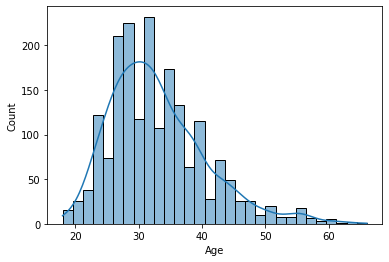

In [22]:
# Plots the Age column as a histogram
# kde refers to the Kernel Density Estimation, which
# gives us a rough estimate of the distribution by age.
sns.histplot(survey['Age'].dropna(), kde=True)

<p><b>Family History of Mental Illness (family_history)</b></p>
The information below informs us that approximately 46% of respondents reported having a family history of mental illness, just below half.

In [23]:
# displays counts of family_history responses,
# where 0 is 'No', 1 is 'Yes'
survey['family_history'].value_counts()

0    1028
1     910
Name: family_history, dtype: int64

<AxesSubplot:xlabel='family_history', ylabel='count'>

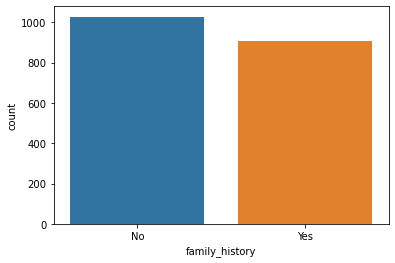

In [27]:
# Shows count of individuals who report having a
# family history of mental illness or not
s = survey['family_history'].astype('category')
s = s.cat.rename_categories(["No", "Yes"])
sns.countplot(x=s)

<p><b>Gender</b></p>
Again, it is not surprising that a survey about the tech workplace, which is male-dominated, to be male-dominated. Approximately 77% of respondents identify as male, 21% identify as female, and less than 1% identify as nonbinary.

In [42]:
# displays counts of Gender responses,
# where 0 is 'Female', 1 is 'Male', 2 is 'Nonbinary'
survey['Gender'].value_counts()

1    1509
0     411
2      18
Name: Gender, dtype: int64

<AxesSubplot:xlabel='Gender', ylabel='count'>

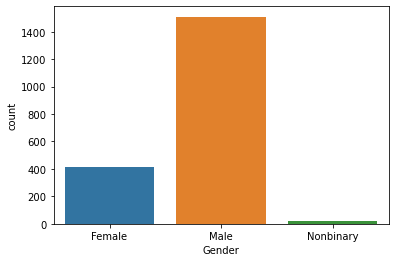

In [28]:
# Shows count of individuals by gender
s.dropna(inplace=True)
s = survey['Gender'].astype('category')
s = s.cat.rename_categories(['Female', 'Male', 'Nonbinary'])
sns.countplot(x=s)

<p><b>Number of Employees (no_employees)</b></p>
Using the grouping determined by the survey, most respondents work in a company of sizes 6-25 or 26-100, and many respondents also work in a significantly larger company of more than 1000 employees.

<AxesSubplot:xlabel='no_employees', ylabel='count'>

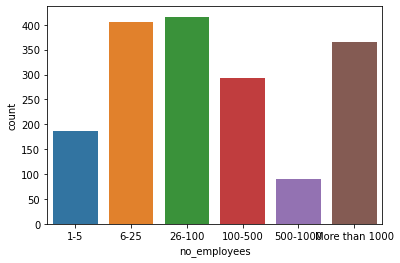

In [29]:
sns.countplot(survey['no_employees'].dropna(), 
              order = ['1-5', '6-25', '26-100', '100-500', '500-1000', 'More than 1000'])

## Exploring how our possible predictors interact with our target value
Using FacetGrid from seaborn, we can see the distribution of certain variables (our predictors) based on another value (our target, work_interfere). Each of the two levels of interference displays its own distribution based on the predictor values.

<p><b>Distribution of Age by Levels of Work Interference</b></p>
Differences in sample size aside, the distributions both display a right skew. This appears to be more indicative of the ages alone, rather than any significant correlation.

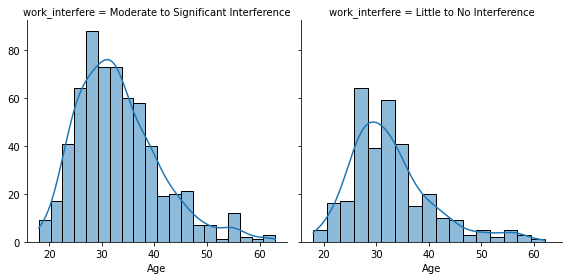

In [41]:
# Displays a distribution by age for each category of work_interfere
g = sns.FacetGrid(survey, col='work_interfere', height=4)
g = g.map(sns.histplot, 'Age', kde=True)

<p><b>Distribution of Gender by Levels of Work Interference</b></p>
Here, we see that females (coded by 1) experience more work interference due to mental health issues than men. The sample size for individuals identifying as non-binary is not large enough to make meaningful observations. This may imply that Gender is a strong predictor value.

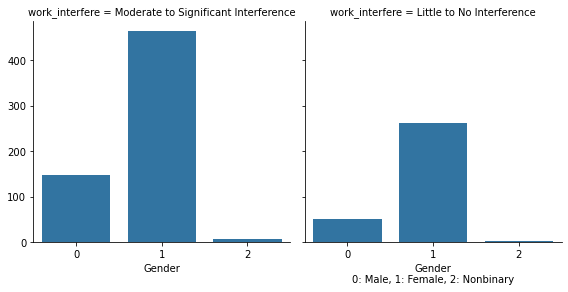

In [65]:
# Displays a distribution by gender for each category of work_interfere
g = sns.FacetGrid(survey, col='work_interfere', height=4)
p = sns.countplot()
g = g.map(sns.countplot, 'Gender')
p.axes.xaxis.label.set_text("Gender\n0: Male, 1: Female, 2: Nonbinary")

<p><b>Distribution of Number of Employees by Levels of Work Interference</b></p>
Just visually, I would not make any inferences about the distribution here. Often, naively plotting values may not be helpful in exploring data. One option is to reconsider how you represent your data (different ranges, making into a continuous variable, etc.).

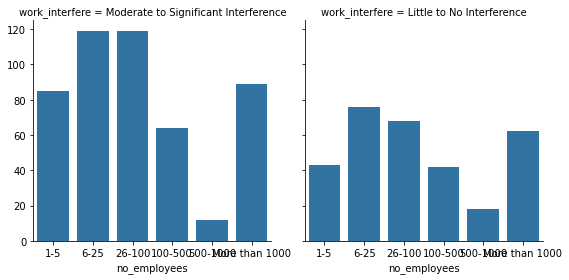

In [66]:
# Displays a distribution by number of employees for each category of work_interfere
# Here, I continue to use a countplot over a histplot, since the latter lacks the order parameter,
# which allows me to manually order the x-axis.
g = sns.FacetGrid(survey, col='work_interfere', height=4)
g = g.map(sns.countplot, 'no_employees', order = ['1-5', '6-25', '26-100', '100-500', '500-1000', 'More than 1000'])

<p><b>Distribution of Workplace Culture/Attitudes by Levels of Work Interference</b></p>
My hypothesis, that a positive workplace culture regarding mental health would reduce work interference is not supported by the plots below. Both of them demonstrate a concentration of moderate workplace_score values, with more employees reporting some sort of work interference (moderate to significant). This may imply that the workplace_score value is not as significant as I initially theorized.

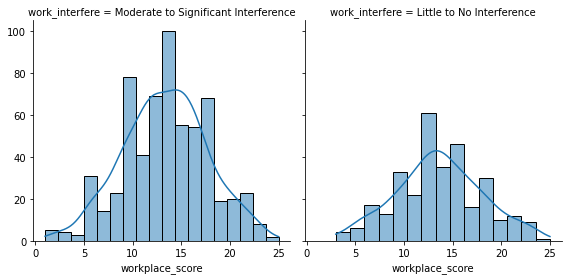

In [33]:
# Displays a distribution by workplace_score for each category of work_interfere
g = sns.FacetGrid(survey, col='work_interfere', height=4)
g = g.map(sns.histplot, 'workplace_score', kde=True)

<p><b>Counts of Family History of Mental Illness by Levels of Work Interference</b></p>
Respondents who indicate having a family history of mental illness also demonstrate having more incidences of work interference due to their own mental health. This may imply that family_history is a significant predictor.

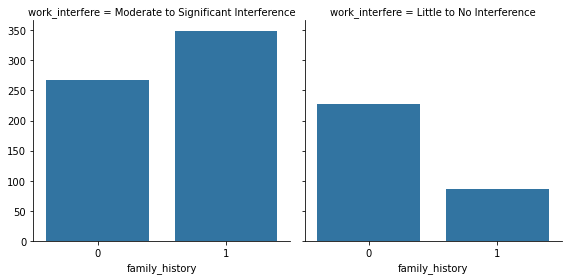

In [68]:
# Displays a distribution by family_history for each category of work_interfere
s = survey.dropna()
g = sns.FacetGrid(s, col='work_interfere', height=4)
g = g.map(sns.countplot, 'family_history')

Our exploratory data analysis has given us some information and predictions going into our Hypothesis Testing and Machine Learning step. Now, we will create a model, interpret its outputs, and discuss its performance. It would be nice to come out on the other end of this step with 100% accuracy...but that won't happen. So, in the next step, we will also discuss possible problem areas in our data collection, management, and analysis.

<b>The Data Science Pipeline isn't always straight-forward!</b> More often than not, it will require that we repeat steps and re-evaluate methods.

# 4. Hypothesis Testing and Machine Learning

## Introduction to Logistic Regression

As mentioned in earlier steps, we are going to use Logistic Regression to try to predict levels of interference for employees in the tech workplace.

<p><b>When to use Logistic Regression?</b></p>
We should use logistic regression when we want to measure the relationship between a categorical variable (in our case, <i>work_interfere,</i> which expresses two categories of work interference due to mental health), and one or more independent variables <i>(Age, Gender, workplace_score, and family_history).</i> For our specific inquiry and the source of our data (a survey), we primarily worked with categorial variables. Logistic Regression is a classification algorithm, making it a suitable choice for our dataset.

<p><b>Binary Logistic Regression</b></p>
Earlier in our code, we translated work_interfere into a variable with only two possible outcomes: <i>Little to No Interference</i> or <i>Moderate to Significant Interference</i>. There are other types of Logistic Regression that can be used to handle target variables having more than two classifications (multinomial, ordinal), but for our purposes, we will use binary logistic regression.

The code below shows how to build a predictive model in <b>Scikit-learn</b>. The documentation can be found <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html">here</a>.

In [35]:
# Drops any NaN values
tidy_survey = survey.replace(to_replace='nan', value=np.nan)
tidy_survey.dropna(inplace=True)

# Displays a summary of our tidy_survey dataset
tidy_survey.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 795 entries, 0 to 1256
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Gender            795 non-null    int64  
 1   Age               795 non-null    float64
 2   family_history    795 non-null    int64  
 3   no_employees      795 non-null    object 
 4   work_interfere    795 non-null    object 
 5   workplace_score   795 non-null    int64  
 6   no_employees_med  795 non-null    float64
dtypes: float64(2), int64(3), object(2)
memory usage: 49.7+ KB


In [72]:
# X will contain our predictor variables, all of which have been converted to
# number values. Y will contain our target value, work_interfere.
X = tidy_survey[['Age', 'workplace_score', 'Gender', 'family_history', 'no_employees_med']]
y = tidy_survey['work_interfere']

# Here, we use train_test_split to split into training and testing sets
# with a 25:75 ratio, test set to training set.

# Scikit docs often set random_state to 42; however, this value does not matter,
# as long as it is set to the same value. It initializes the random number generator,
# and the specific number doesn't have any meaningful effects on our prediction model.
X_train, X_test,y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=42)

# logreg instantiates the model
logreg = LogisticRegression()

# Fits our model with the given data
lm = logreg.fit(X_train,y_train)

# Creates an array of predictions
prediction = logreg.predict(X_test)

# Prints the coefficients for the predictor vars
# and the intercept
print(lm.coef_, lm.intercept_)

[[-1.06015793e-02 -3.64750981e-02 -2.99555231e-01  1.07580271e+00
  -1.53807163e-04]] [1.21010358]


Let's put this in a DataFrame, just for clarity. Then we'll discuss what these coefficients indicate.

In [73]:
# Inserts predictors and corresponding coefficients into a DataFrame
preds = ['Age', 'workplace_score', 'Gender', 'family_history', 'no_employees_med']
model_results = pd.DataFrame([preds, lm.coef_[0]]).transpose()
model_results.columns = ['Predictors', 'Coefficients']
model_results.sort_values('Coefficients', inplace=True)
model_results

,Predictors,Coefficients
2,Gender,-0.299555
1,workplace_score,-0.0364751
0,Age,-0.0106016
4,no_employees_med,-0.000153807
3,family_history,1.0758


<b>Interpreting the coefficients</b>
<li>Gender is the lowest coefficient we have, as it refers to the 'Male' classification, i.e., male respondents are <i>less likely</i> to report work interference due to their mental health.</li>
<li>Positive numbers indicate a positive correlation. Based on this, we can say that respondents not reporting a history of mental illness in the family are less likely to experience work interference.</li>

This doesn't quite align with the earlier predictions. As mentioned earlier, we can't depend on our model to perform with 100% accuracy. Our next step will be to evaluate how our predictive model performed.

## Evaluating the performance of our model with a Confusion Matrix

A confusion matrix, also known as an error matrix, can further our understanding by visualizing the number of correct and incorrect predictions for our classifications.

In [38]:
# Creates a Confusion Matrix to evaluate the performance of the predictive model
cnf_matrix = metrics.confusion_matrix(y_test, prediction)

# We will get a 2x2 matrix (due to our binary logistic regression)
# where 26 and 97 represent actual predictions (True Positive, and True Negative)
# and 54 and 22 representing incorrect predictions, Type 1 and Type 2
# Errors, respectively.
cnf_matrix

array([[26, 54],
       [22, 97]])

We can go even further and create a heatmap from our cnf_matrix, as seen below. This does not change our prediction/error counts, it simply provides a visual where, the more concentrated/darker a color becomes, it indicates a higher count for that classification. <b>Our heatmap shows a significant concentration of incorrectly predicted values <u>(specifically, Type 1 Errors, which are generally thought of as the worse of the two),</u> which should prompt us to reevaluate our model's performance.</b>

We will use seaborn to create our heatmap. The documentation can be found <a href="https://seaborn.pydata.org/generated/seaborn.heatmap.html">here</a>.

Text(0.5, 15.0, 'Predicted')

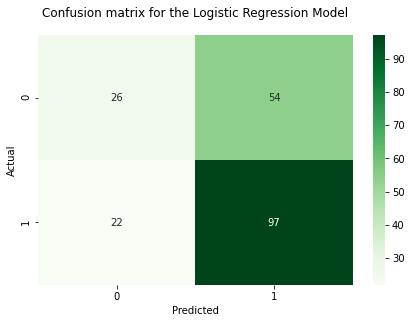

In [80]:
# Indicates our classification names
class_names=['Little to No Interference','Moderate to Significant Interference']

# Sets the axes and labels for our heatmap
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Uses Seaborn to create the heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap=plt.cm.Greens ,fmt='g')

# Sets axes layouts and labels
ax.xaxis.set_label_position("bottom")
plt.tight_layout()
plt.title('Confusion matrix for the Logistic Regression Model', y=1.05)
plt.ylabel('Actual')
plt.xlabel('Predicted')

## Interpreting the classification_report
<p></p>
<li>precision: Identifies how many are correctly classified among ths specified class.</li>
<li>recall: Indicates the amount of some class that can be found among the whole dataset class amount.</li>
<li>f1-score: the harmonic mean between precision and recall.</li>
<li>support: count of occurences for each classification</li>
<p></p>

In [74]:
# Outputs the key metrics for our classification
print(classification_report(y_test,prediction))

                                      precision    recall  f1-score   support

           Little to No Interference       0.54      0.33      0.41        80
Moderate to Significant Interference       0.64      0.82      0.72       119

                            accuracy                           0.62       199
                           macro avg       0.59      0.57      0.56       199
                        weighted avg       0.60      0.62      0.59       199



<b>What does this mean?:</b> The logistic regression created a model based on our training and test sets. <b>recall </b> shows us the product of our fitted model: with 33% of respondents having little to no work interference due to mental health, and 82% of respondents reporting some sort of work interference due to mental health. <b>precision </b> proceeds to tell us how accurate this is, compared to our testing set (actual results).

<b><i>Our model has an accuracy of 0.62, which...isn't great.</i></b>

<i>So, what do we do now?</i>
<b>Improve our model's accuracy by going back and handling our data differently:</b> this may include normalizing/standardizing values, looking for class imbalances in our dataset, or rework how we classify our predictors and targets. When doing this, it's important to optimize accuracy on your training set, not your testing set, to avoid overfitting.

However, for our purposes, we won't be going back and making these changes; instead, <b>we are going to discuss the likely causes of our lack of accuracy.<b>

# 5. Insight and Discussion

## Walking back through the Data Science Pipeline
Now that we've done one pass through the data science pipeline, our next step is going to be walking through it <i>again,</i> instead this time to review our methods, identify things we could have done differently, and discuss potential problem areas.

### 1. Data Collection
<p></p>
<li><b>Handling work_interfere:</b> Instead of manipulating the 2016 dataset to fit with the 2014 dataset, which was less informative, it may have increased accuracy to use multiple-imputation.</li>
<li><b>Choice of datasets:</b> The chosen datasets may have not been best-suited to answer the inquiry about productivity. Although work_interfere describes productivity in the sense of 'least interference due to mental health', it may have been a stretch and potentially answered better with another dataset. Additionally, 2014 and 2016 could be considered outdated, especially when it comes to mental wellness attitudes, which have significantly evolved and shifted over the past few years.</li>

### 2. Data Management and Representation and 3. Exploratory Data Analysis
<p></p>
<li><b>Handling of workplace_score:</b> Fine-tuning the way this score was calculated by differently weighting questions is something I would be interested in seeing the effects of. The way I chose to calculate it, giving positive marks and negative marks based on an employee's perception of their workplace, possibly communicated arbitrary information, especially when compared to stronger predictors, such as family_history and Gender.</li>
<li><b>Lack of normalization/standardization of predictor variables: </b>earlier in the code, we naively translated categorical variables into numerical ones for gender and family_history. The other predictor variables, age and workplace_score are continuous variables. It is possible certain variables are dominating the model. Normalizing and differently handling how the data is represented may result in a better balanced training set.</li>


### 4. Discussing Predictive Model Performance (Hypothesis Testing, Machine Learning)
<p></p>
<li><b>Our target variable lacked balance: </b>In order to demonstrate a binary logstic regression, we manipulated our target variable, <i>work_interfere,</i> to only produce two results. 'Little to No Interference' consisted of survey responses of 'No', 'Never', and 'Rarely', and 'Moderate to Significant Interference' consisted of 'Sometimes', 'Yes', 'Often'. However, the more moderate category of 'Sometimes' had the most responses, and likely produced an imbalance in favor of the 'Moderate to Significant Interference'. <i>A less statistics-related observation...</i> I likely let this slide because I wanted to see a strong and obvious correlation between my predictor values and mental illness's impact on work_interfere.</li> 
<li><b>General handling of missing values/NaN and sample size: </b>Outside of work_interfere, we did not do any meaningful imputation in dealing with our missing values. This resulted in a significant reduction of our dataset. Similar to a lot of the discussions above, more fine-tuning could have possibly resulted in different model behavior.</li> 
<p></p>

# Final Thoughts
So...what about the initial inquiry? Do workplace attitudes about mental health influence productivity?

Based on the model we have: they do not. However, the problem areas we discussed have indicated numerous ways this inquiry can be re-explored, whether with a whole new dataset, different treatment of our variables, or a different ML model.

As you can see, this introduction and tutorial about the data science pipeline is not a straightfoward one. Though the way we collect, manage, and analyze the data is important, there is great value in the discussion aspect of the data science pipeline: understanding our methods, figuring out how we can improve, and trying the same steps again with new perspectives.